## Import Packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

## Import Data from csv to Dataframe

In [2]:
df = pd.read_csv("online_transaction.csv")
df.head()

,transaction_id,customer_id,transaction_date,product_id,product_name,product_category,quantity,price
0,16679,17850,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71
1,16680,17850,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71
2,16681,17850,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05
3,16682,17850,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53
4,16682,17850,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    52924 non-null  int64  
 1   customer_id       52924 non-null  int64  
 2   transaction_date  52924 non-null  object 
 3   product_id        52924 non-null  object 
 4   product_name      52924 non-null  object 
 5   product_category  52924 non-null  object 
 6   quantity          52924 non-null  int64  
 7   price             52924 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 3.2+ MB


## Data Cleansing

In [13]:
df_clean = df.copy()
# Create column date
df_clean["transaction_date"] = pd.to_datetime(df_clean["transaction_date"]).dt.date.astype("datetime64[ns]")
# create a year_month column
df_clean["year_month"] = df_clean["transaction_date"].dt.to_period('M')
# Make all product_names lowercase
df_clean["product_name"] = df_clean["product_name"].str.lower()
# create an amount value, namely the product of quantity and price
df_clean["amount"] = df_clean["quantity"]*df_clean["price"]
# Replace the product name of a product_id that has several product_names with one of the product_names that appears most frequently
most_freq_product_name = df_clean.groupby(['product_id','product_name'], as_index=False).agg(order_cnt=('transaction_id','nunique')).sort_values(['product_id','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_id')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_clean = df_clean.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_id')
df_clean['product_name'] = df_clean['most_freq_product_name']
df_clean = df_clean.drop(columns='most_freq_product_name')
# convert customer_id and transaction_id to string
df_clean["customer_id"] = df_clean["customer_id"].astype(str)
df_clean["transaction_id"] = df_clean["transaction_id"].astype(str)

In [14]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    52924 non-null  object        
 1   customer_id       52924 non-null  object        
 2   transaction_date  52924 non-null  datetime64[ns]
 3   product_id        52924 non-null  object        
 4   product_name      52924 non-null  object        
 5   product_category  52924 non-null  object        
 6   quantity          52924 non-null  int64         
 7   price             52924 non-null  float64       
 8   year_month        52924 non-null  period[M]     
 9   amount            52924 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5), period[M](1)
memory usage: 4.0+ MB


## Create a user retention group

### Aggregate transaction data into a summary form of total transactions/orders for each user every month

In [6]:
df_user_monthly = df_clean.groupby(['customer_id','year_month'],as_index=False).agg(order_cnt=('transaction_id','nunique'))
df_user_monthly

,customer_id,year_month,order_cnt
0,12346,2019-09,1
1,12347,2019-03,13
2,12347,2019-11,18
3,12348,2019-06,4
4,12348,2019-10,4
...,...,...,...
2573,18269,2019-04,1
2574,18269,2019-06,1
2575,18277,2019-10,1
2576,18283,2019-07,22


### Create a column as a cohort of users

In [7]:
df_user_monthly['cohort'] = df_user_monthly.groupby('customer_id')['year_month'].transform('min')
df_user_monthly

,customer_id,year_month,order_cnt,cohort
0,12346,2019-09,1,2019-09
1,12347,2019-03,13,2019-03
2,12347,2019-11,18,2019-03
3,12348,2019-06,4,2019-06
4,12348,2019-10,4,2019-06
...,...,...,...,...
2573,18269,2019-04,1,2019-04
2574,18269,2019-06,1,2019-04
2575,18277,2019-10,1,2019-10
2576,18283,2019-07,22,2019-07


### Calculate the month distance between the month of the transaction and the month of the first transaction and add it to 1 so that the month distance 0 becomes 1 which means the first month, etc.

In [8]:
from operator import attrgetter

df_user_monthly['period_num'] = (df_user_monthly['year_month']-df_user_monthly['cohort']).apply(attrgetter('n'))+1
df_user_monthly

,customer_id,year_month,order_cnt,cohort,period_num
0,12346,2019-09,1,2019-09,1
1,12347,2019-03,13,2019-03,1
2,12347,2019-11,18,2019-03,9
3,12348,2019-06,4,2019-06,1
4,12348,2019-10,4,2019-06,5
...,...,...,...,...,...
2573,18269,2019-04,1,2019-04,1
2574,18269,2019-06,1,2019-04,3
2575,18277,2019-10,1,2019-10,1
2576,18283,2019-07,22,2019-07,1


### Pivot table with index in the form of cohort, column in the form of month distance, and value is the number of unique users (unique count of user IDs)

In [9]:
df_cohort_pivot = pd.pivot_table(df_user_monthly, index='cohort', columns='period_num', values='customer_id', aggfunc=pd.Series.nunique)
df_cohort_pivot

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2019-01,215.0,13.0,24.0,34.0,23.0,44.0,35.0,47.0,23.0,28.0,20.0,34.0
2019-02,96.0,7.0,9.0,16.0,17.0,22.0,19.0,15.0,12.0,11.0,16.0,NaN
2019-03,177.0,18.0,35.0,25.0,32.0,33.0,22.0,22.0,15.0,19.0,NaN,NaN
2019-04,163.0,14.0,24.0,24.0,18.0,15.0,10.0,16.0,12.0,NaN,NaN,NaN
2019-05,112.0,12.0,9.0,13.0,10.0,13.0,14.0,8.0,NaN,NaN,NaN,NaN
2019-06,137.0,20.0,22.0,12.0,11.0,14.0,11.0,NaN,NaN,NaN,NaN,NaN
2019-07,94.0,13.0,4.0,6.0,11.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,135.0,14.0,15.0,10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,78.0,6.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate the number of users in each cohort (users who made their first transaction in that month) and divide all the values ​​in the pivot table by that value as the retention rate

In [10]:
cohort_size = df_cohort_pivot.iloc[:, 0]
cohort_size

cohort
2019-01    215.0
2019-02     96.0
2019-03    177.0
2019-04    163.0
2019-05    112.0
2019-06    137.0
2019-07     94.0
2019-08    135.0
2019-09     78.0
2019-10     87.0
2019-11     68.0
2019-12    106.0
Freq: M, Name: 1, dtype: float64

In [11]:
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis=0)
df_retention_cohort

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2019-01,1.0,0.060465,0.111628,0.158140,0.106977,0.204651,0.162791,0.218605,0.106977,0.130233,0.093023,0.15814
2019-02,1.0,0.072917,0.093750,0.166667,0.177083,0.229167,0.197917,0.156250,0.125000,0.114583,0.166667,NaN
2019-03,1.0,0.101695,0.197740,0.141243,0.180791,0.186441,0.124294,0.124294,0.084746,0.107345,NaN,NaN
2019-04,1.0,0.085890,0.147239,0.147239,0.110429,0.092025,0.061350,0.098160,0.073620,NaN,NaN,NaN
2019-05,1.0,0.107143,0.080357,0.116071,0.089286,0.116071,0.125000,0.071429,NaN,NaN,NaN,NaN
2019-06,1.0,0.145985,0.160584,0.087591,0.080292,0.102190,0.080292,NaN,NaN,NaN,NaN,NaN
2019-07,1.0,0.138298,0.042553,0.063830,0.117021,0.095745,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,1.0,0.103704,0.111111,0.074074,0.059259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,1.0,0.076923,0.038462,0.025641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Display a pivot table that already contains the retention rate value in the heatmap

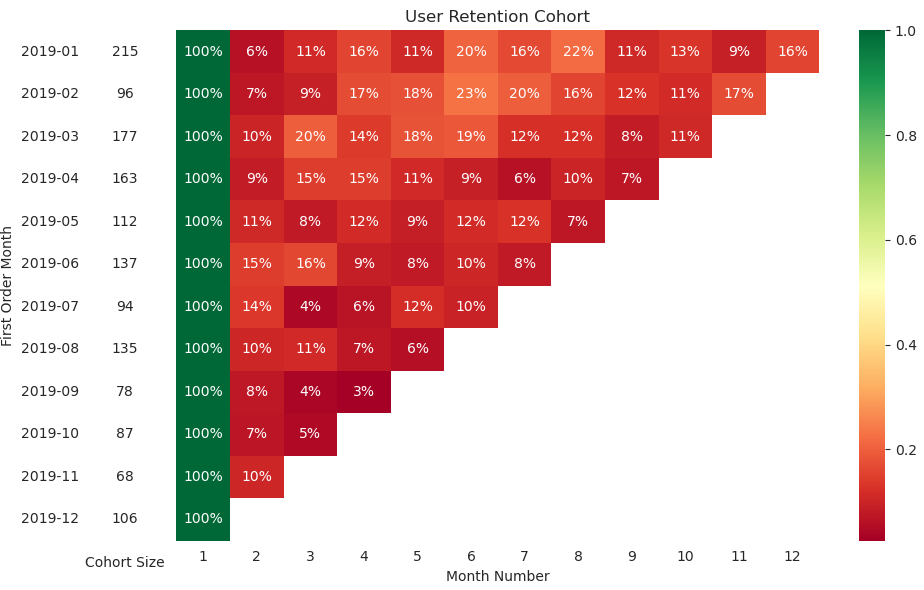

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

with sns.axes_style('white'):

    fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True, gridspec_kw={'width_ratios':[1, 11]})

    # user retention cohort
    sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
    ax[1].set_title('User Retention Cohort')
    ax[1].set(xlabel='Month Number', ylabel='')

    # cohort size
    df_cohort_size = pd.DataFrame(cohort_size)
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(df_cohort_size, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
    ax[0].tick_params(bottom=False)
    ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])

    fig.tight_layout()

## Conclusion

* The customers who made the most transactions occurred in January with 215.
* unfortunately during 2019 the majority of customers did not return. This can be seen in the heatmap almost every month, the retention value is less than 20%
* The low retention value is a concern, therefore it is necessary to improve services and create special programs so that customers can make transactions again.